In [1]:
import os
from pathlib import Path

# Kaggle environment setup
IS_KAGGLE = os.path.exists('/kaggle')

if IS_KAGGLE:
    # Running on Kaggle
    BASE_DIR = Path('/kaggle/working')
    os.chdir(BASE_DIR)
    print(" Running on Kaggle")
else:
    # Running locally
    BASE_DIR = Path.cwd().parent.parent
    print(" Running locally")

print(f"Base directory: {BASE_DIR}")

# Create necessary directories
(BASE_DIR / "models").mkdir(exist_ok=True)
(BASE_DIR / "config").mkdir(exist_ok=True)
print(" Directories created")

 Running on Kaggle
Base directory: /kaggle/working
 Directories created


In [2]:
# Install LLaMA Factory nếu chưa có
!pip install "llamafactory[torch,metrics]" -q
!pip install deepspeed accelerate bitsandbytes peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.5/398.5 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 136.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Verify installation
!llamafactory-cli version

2026-01-02 18:35:02.431130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767378902.556716     289 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767378902.591967     289 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767378902.886626     289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767378902.886655     289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767378902.886658     289 computation_placer.cc:177] computation placer alr

In [4]:
import json

# Dataset paths - adjust based on environment
if IS_KAGGLE:
    # On Kaggle: assume data uploaded as a dataset
    # IMPORTANT: Change this to match your Kaggle dataset name!
    DATA_INPUT = Path('/kaggle/input/data-llama/llama-dataset')
    TRAIN_DATA = Path(DATA_INPUT / "vqa_vietnamese_train.json")
    EVAL_DATA = Path(DATA_INPUT / "vqa_vietnamese_test.json")
    IMAGE_DIR = Path("/kaggle/input/vqa-dataset/images_flat/images_flat")
else:
    # Local paths
    DATA_INPUT = BASE_DIR / "llama-dataset"
    TRAIN_DATA = DATA_INPUT / "vqa_vietnamese_train.json"
    # EVAL_DATA = DATA_INPUT / "vqa_vietnamese_test.json"
    IMAGE_DIR = BASE_DIR / "data" / "raw" / "images_flat"

# Verify files exist
print(f"\n Data paths:")
print(f"  Train: {TRAIN_DATA} - {'Found' if TRAIN_DATA.exists() else 'NOT FOUND'}")
print(f"  Eval: {EVAL_DATA} - {'Found' if EVAL_DATA.exists() else 'NOT FOUND'}")
print(f"  Images: {IMAGE_DIR} - {'Found' if IMAGE_DIR.exists() else 'NOT FOUND'}")

# Load data
with open(TRAIN_DATA, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

with open(EVAL_DATA, 'r', encoding='utf-8') as f:
    eval_data = json.load(f)

print(f"\n Dataset size:")
print(f"  Train samples: {len(train_data)}")
print(f"  Eval samples: {len(eval_data)}")


 Data paths:
  Train: /kaggle/input/data-llama/llama-dataset/vqa_vietnamese_train.json - Found
  Eval: /kaggle/input/data-llama/llama-dataset/vqa_vietnamese_test.json - Found
  Images: /kaggle/input/vqa-dataset/images_flat/images_flat - Found

 Dataset size:
  Train samples: 7598
  Eval samples: 60


In [5]:
# Display sample
sample = train_data[0]
print("="*80)
print("SAMPLE TRAINING EXAMPLE")
print("="*80)
print(f"\nImage: {sample['images']}")
print(f"\n{sample['conversations'][0]['from']}: {sample['conversations'][0]['value'][:200]}...")
print(f"\n{sample['conversations'][1]['from']}: {sample['conversations'][1]['value'][:400]}...")
print(f"\n{sample['conversations'][2]['from']}: {sample['conversations'][2]['value'][:300]}...")

SAMPLE TRAINING EXAMPLE

Image: ['005000.jpg']

system: Bạn là trợ lý VQA chuyên về lịch sử và văn hóa Việt Nam. Trả lời câu hỏi dựa trên HÌNH ẢNH là chính. Mô tả hình ảnh và văn bản OCR chỉ là thông tin tham khảo, có thể không chính xác. Kiến thức bổ sung...

human: <image>

Dựa vào mô tả hình ảnh: Hình ảnh cho thấy một bé gái trẻ đang sử dụng một chiếc cột bắc bằng nhựa màu xanh dương nhạt. Cột bắc có hai đầu được gắn vào hai chân của bé gái, giúp bé gái đứng thẳng. Bé gái mặc áo thun kẻ sọc xanh trắng, quần màu xám, mang giày thể thao màu hồng. Bé gái đang đứng thẳng, hai chân của bé gái được giữ chắc chắn bởi hai đầu cột bắc.

Thông tin văn bản trong ảnh: ...

gpt: Cà kheo trong ảnh hiện đại hơn.

Cà kheo truyền thống thường được làm từ gỗ hoặc tre, có thiết kế đơn giản hơn.  Cà kheo trong hình ảnh có vẻ được làm từ kim loại, thiết kế chắc chắn và an toàn hơn, có thể đáp ứng tiêu chuẩn an toàn hiện đại. Sự khác biệt này phản ánh sự phát triển và thích ứng của ...


In [6]:
import copy

def convert_to_absolute_paths(data, image_dir):
    """Convert image filenames to absolute paths"""
    new_data = []
    for item in data:
        new_item = copy.deepcopy(item)
        # Convert images list to absolute paths
        if 'images' in new_item:
            new_item['images'] = [str(image_dir / img) for img in new_item['images']]
        new_data.append(new_item)
    return new_data

# Convert train and test data
train_data_abs = convert_to_absolute_paths(train_data, IMAGE_DIR)
eval_data_abs = convert_to_absolute_paths(eval_data, IMAGE_DIR)

# Save converted data to working directory
DATA_OUT = BASE_DIR / "data"
DATA_OUT.mkdir(exist_ok=True)
TRAIN_DATA_ABS = DATA_OUT / "vqa_train_abs.json"
EVAL_DATA_ABS = DATA_OUT / "vqa_eval_abs.json"

with open(TRAIN_DATA_ABS, 'w', encoding='utf-8') as f:
    json.dump(train_data_abs, f, ensure_ascii=False, indent=2)

with open(EVAL_DATA_ABS, 'w', encoding='utf-8') as f:
    json.dump(eval_data_abs, f, ensure_ascii=False, indent=2)

print(f" Converted train data: {TRAIN_DATA_ABS}")
# print(f" Converted test data: {EVAL_DATA_ABS}")

# Verify conversion
print(f"\n Sample image path (before): {train_data[0]['images']}")
print(f" Sample image path (after): {train_data_abs[0]['images']}")

# Check if image exists
sample_img = train_data_abs[0]['images'][0]
print(f"\n Image exists: {Path(sample_img).exists()}")

 Converted train data: /kaggle/working/data/vqa_train_abs.json

 Sample image path (before): ['005000.jpg']
 Sample image path (after): ['/kaggle/input/vqa-dataset/images_flat/images_flat/005000.jpg']

 Image exists: True


In [7]:
# Tạo dataset_info.json với paths MỚI
dataset_info = {
    "vqa_vietnamese_train": {
        "file_name": str(TRAIN_DATA_ABS),  # Use converted file
        "formatting": "sharegpt",
        "columns": {
            "messages": "conversations",
            "images": "images"
        },
        "tags": {
            "role_tag": "from",
            "content_tag": "value",
            "user_tag": "human",
            "assistant_tag": "gpt",
            "system_tag": "system"
        }
    },
    "vqa_vietnamese_test": {
        "file_name": str(EVAL_DATA_ABS),  # Use converted file
        "formatting": "sharegpt",
        "columns": {
            "messages": "conversations",
            "images": "images"
        },
        "tags": {
            "role_tag": "from",
            "content_tag": "value",
            "user_tag": "human",
            "assistant_tag": "gpt",
            "system_tag": "system"
        }
    }
}

DATASET_INFO_PATH = BASE_DIR / "config" / "dataset_info.json"

with open(DATASET_INFO_PATH, 'w', encoding='utf-8') as f:
    json.dump(dataset_info, f, indent=2, ensure_ascii=False)

print(f"\n Saved dataset_info.json to {DATASET_INFO_PATH}")
print(f"\n Dataset info:")
print(json.dumps(dataset_info, indent=2, ensure_ascii=False))

# Verify image folder exists
print(f"\n Image folder: {IMAGE_DIR}")
print(f"   Exists: {IMAGE_DIR.exists()}")
if IMAGE_DIR.exists():
    sample_files = list(IMAGE_DIR.iterdir())[:3]
    print(f"   Sample files: {[f.name for f in sample_files]}")

# print(f" Saved dataset_info.json to {DATASET_INFO_PATH}")
# print(f"\n Dataset info:")
# print(json.dumps(dataset_info, indent=2, ensure_ascii=False))
# print(f"\n Dataset info:")
# print(json.dumps(dataset_info, indent=2, ensure_ascii=False))


 Saved dataset_info.json to /kaggle/working/config/dataset_info.json

 Dataset info:
{
  "vqa_vietnamese_train": {
    "file_name": "/kaggle/working/data/vqa_train_abs.json",
    "formatting": "sharegpt",
    "columns": {
      "messages": "conversations",
      "images": "images"
    },
    "tags": {
      "role_tag": "from",
      "content_tag": "value",
      "user_tag": "human",
      "assistant_tag": "gpt",
      "system_tag": "system"
    }
  },
  "vqa_vietnamese_test": {
    "file_name": "/kaggle/working/data/vqa_eval_abs.json",
    "formatting": "sharegpt",
    "columns": {
      "messages": "conversations",
      "images": "images"
    },
    "tags": {
      "role_tag": "from",
      "content_tag": "value",
      "user_tag": "human",
      "assistant_tag": "gpt",
      "system_tag": "system"
    }
  }
}

 Image folder: /kaggle/input/vqa-dataset/images_flat/images_flat
   Exists: True
   Sample files: ['004725.png', '001183.png', '001506.jpg']


In [8]:
# Training config with dynamic paths
OUTPUT_DIR = BASE_DIR / 'models' / 'qwen2vl-7b-vqa-grounded'
CONFIG_DIR = BASE_DIR / 'config'

config_yaml = f"""### Model
model_name_or_path: Qwen/Qwen2-VL-7B-Instruct
trust_remote_code: true

### Method
stage: sft
do_train: true
finetuning_type: lora
lora_target: all
lora_rank: 64
lora_alpha: 128
lora_dropout: 0.05

### Dataset
dataset: vqa_vietnamese_train
dataset_dir: /kaggle/working/config
template: qwen2_vl
cutoff_len: 2048
overwrite_cache: true
preprocessing_num_workers: 4

### Image settings
freeze_vision_tower: true

### Output
output_dir: /kaggle/working/models/qwen2vl-7b-vqa-grounded
logging_steps: 10
save_steps: 100
save_total_limit: 3
plot_loss: true
overwrite_output_dir: true

### Training hyperparameters
per_device_train_batch_size: 4
gradient_accumulation_steps: 4
learning_rate: 5.0e-5
num_train_epochs: 3
lr_scheduler_type: cosine
warmup_ratio: 0.1
bf16: false
fp16: true

### Optimization
gradient_checkpointing: true
optim: adamw_torch

### Quantization 
quantization_bit: 4
quantization_method: bitsandbytes

### Evaluation - QUAN TRỌNG: eval_steps = save_steps
do_eval: true
eval_dataset: vqa_vietnamese_test
eval_strategy: steps
eval_steps: 100
per_device_eval_batch_size: 1
load_best_model_at_end: true
metric_for_best_model: eval_loss
greater_is_better: false

### Logging
report_to: none

"""

CONFIG_PATH = CONFIG_DIR / "qwen2vl_7b_grounded.yaml"

with open(CONFIG_PATH, 'w', encoding='utf-8') as f:
    f.write(config_yaml)

print(f" Saved config to {CONFIG_PATH}")
print("\n" + "="*60)
print(" TRAINING CONFIG")
print("="*60)
print(config_yaml)

 Saved config to /kaggle/working/config/qwen2vl_7b_grounded.yaml

 TRAINING CONFIG
### Model
model_name_or_path: Qwen/Qwen2-VL-7B-Instruct
trust_remote_code: true

### Method
stage: sft
do_train: true
finetuning_type: lora
lora_target: all
lora_rank: 64
lora_alpha: 128
lora_dropout: 0.05

### Dataset
dataset: vqa_vietnamese_train
dataset_dir: /kaggle/working/config
template: qwen2_vl
cutoff_len: 2048
overwrite_cache: true
preprocessing_num_workers: 4

### Image settings
freeze_vision_tower: true

### Output
output_dir: /kaggle/working/models/qwen2vl-7b-vqa-grounded
logging_steps: 10
save_steps: 100
save_total_limit: 3
plot_loss: true
overwrite_output_dir: true

### Training hyperparameters
per_device_train_batch_size: 4
gradient_accumulation_steps: 4
learning_rate: 5.0e-5
num_train_epochs: 3
lr_scheduler_type: cosine
warmup_ratio: 0.1
bf16: false
fp16: true

### Optimization
gradient_checkpointing: true
optim: adamw_torch

### Quantization 
quantization_bit: 4
quantization_method: bits

In [9]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU count:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")
        print(f"  Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")

CUDA available: True
CUDA version: 12.6
GPU count: 1

GPU 0: NVIDIA H100 80GB HBM3
  Memory: 79.44 GB
  Allocated: 0.00 GB
  Cached: 0.00 GB


In [10]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [11]:
# Start training
print(" Starting fine-tuning...")
print(f"   Config: {CONFIG_PATH}")
print(f"   Output: {OUTPUT_DIR}")
print()

!llamafactory-cli train {CONFIG_PATH}

 Starting fine-tuning...
   Config: /kaggle/working/config/qwen2vl_7b_grounded.yaml
   Output: /kaggle/working/models/qwen2vl-7b-vqa-grounded

2026-01-02 18:35:19.992003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767378920.007841     358 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767378920.012469     358 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767378920.024161     358 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767378920.024189     358 computation_placer.cc:177] computation placer already registered. Please check li

In [12]:
# Check output directory
output_dir = BASE_DIR / "models" / "qwen2vl-7b-vqa-grounded"

if output_dir.exists():
    print(f"Output directory: {output_dir}")
    print("\nContents:")
    !ls -lh {output_dir}
else:
    print(f"Training not started yet. Output will be at: {output_dir}")

Output directory: /kaggle/working/models/qwen2vl-7b-vqa-grounded

Contents:
total 632M
-rw-r--r-- 1 root root  938 Jan  2 20:37 adapter_config.json
-rw-r--r-- 1 root root 617M Jan  2 20:37 adapter_model.safetensors
-rw-r--r-- 1 root root  392 Jan  2 20:37 added_tokens.json
-rw-r--r-- 1 root root  344 Jan  2 20:37 all_results.json
-rw-r--r-- 1 root root 1017 Jan  2 20:37 chat_template.jinja
drwxr-xr-x 2 root root 4.0K Jan  2 20:35 checkpoint-1400
drwxr-xr-x 2 root root 4.0K Jan  2 20:37 checkpoint-1425
drwxr-xr-x 2 root root 4.0K Jan  2 19:53 checkpoint-900
-rw-r--r-- 1 root root  159 Jan  2 20:37 eval_results.json
-rw-r--r-- 1 root root 1.6M Jan  2 20:37 merges.txt
-rw-r--r-- 1 root root  826 Jan  2 20:37 preprocessor_config.json
-rw-r--r-- 1 root root 2.3K Jan  2 20:37 README.md
-rw-r--r-- 1 root root  613 Jan  2 20:37 special_tokens_map.json
-rw-r--r-- 1 root root 3.3K Jan  2 20:37 tokenizer_config.json
-rw-r--r-- 1 root root  11M Jan  2 20:37 tokenizer.json
-rw-r--r-- 1 root root  3

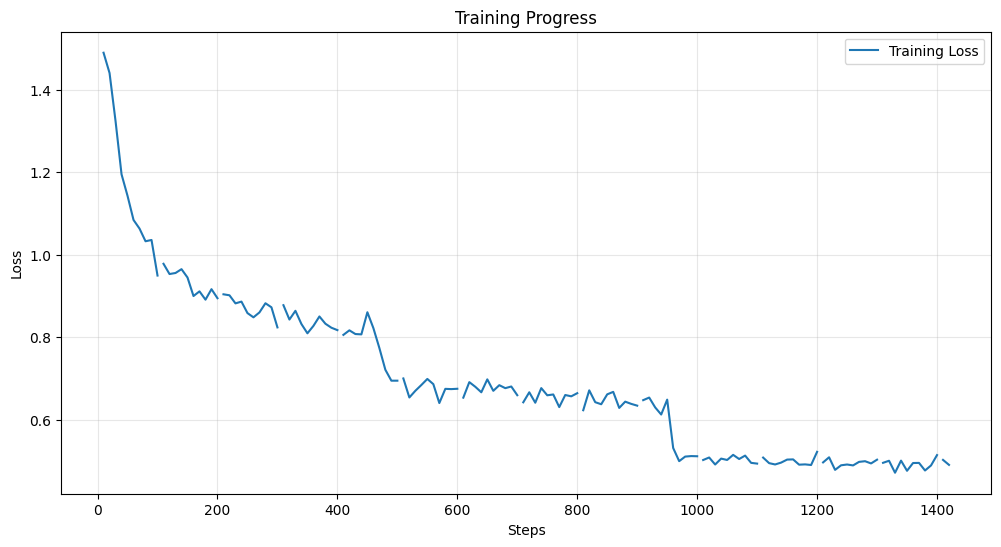


Latest loss: nan
Steps completed: 1425


In [13]:
# Plot training loss if available
import matplotlib.pyplot as plt
import pandas as pd

trainer_log = output_dir / "trainer_log.jsonl"

if trainer_log.exists():
    logs = []
    with open(trainer_log, 'r') as f:
        for line in f:
            logs.append(json.loads(line))
    
    df = pd.DataFrame(logs)
    
    if 'loss' in df.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(df['current_steps'], df['loss'], label='Training Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"\nLatest loss: {df['loss'].iloc[-1]:.4f}")
        print(f"Steps completed: {df['current_steps'].iloc[-1]}")
    else:
        print("No loss data yet")
else:
    print("No training log found yet")

In [14]:
# Export config with dynamic paths
export_config = f"""### Model
model_name_or_path: Qwen/Qwen2-VL-7B-Instruct
adapter_name_or_path: {BASE_DIR / 'models' / 'qwen2vl-7b-vqa-grounded'}
template: qwen2_vl
finetuning_type: lora
trust_remote_code: true

### Export
export_dir: {BASE_DIR / 'models' / 'qwen2vl-7b-vqa-grounded-merged'}
export_size: 2
export_device: cpu
export_legacy_format: false
"""

EXPORT_CONFIG_PATH = BASE_DIR / "config" / "export_model.yaml"
with open(EXPORT_CONFIG_PATH, 'w') as f:
    f.write(export_config)

print(f" Created export config: {EXPORT_CONFIG_PATH}")

 Created export config: /kaggle/working/config/export_model.yaml
